In [3]:
debug = 2
g = 0

thisyear = 2018

print('Importing packages...')
import os
import pandas
import numpy as np
import time
#import zipfile
import geopandas
from pprint import pprint
from matplotlib import pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Point

pandas.set_option('display.max_colwidth', -1)


# Directories to look in
thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
data_dir = '/home/idies/workspace/Temporary/raddick/cra_scratch_final/'
jobs_dir = data_dir + 'lodes_wac/'

#census_dir = data_dir + 'acs5/'

output_data_dir = thisdir + 'final_data/'
#baltimore_dir = thisdir + 'baltimore/'

census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'
cities_tracts_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/cbsa_central_cities/v2/'



shapefile_dir = census_shapefile_tiger_basedir + '{0:.0f}/TRACT/'.format(thisyear)

acs5_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/'

code_lookup_dir = thisdir + 'code_guide_lookups/'
inflation_dir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/inflation/'
extrasdir = '/home/idies/workspace/Storage/raddick/census/extras/'

#city_data_dir = thisdir + 'city_data/'
scale = 1


os.chdir(thisdir)
g = 0 # global time

print('Now in directory: {0:}'.format(os.getcwd()))
print('ok')

Importing packages...
Now in directory: /home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act
ok


In [ ]:
s = time.time()

years = np.arange(2018, 2009, -1)

filenames_df = pandas.DataFrame(data=[x for x in os.listdir(cities_tracts_dir) if ('central_city_tracts' in x) and (x[-4:] == '.shp')], columns=['filename'])
filenames_df = filenames_df.assign(state_number = filenames_df['filename'].apply(lambda x: int(x[-6:-4])))
filenames_df = filenames_df.sort_values(by = 'state_number')
filenames_df = filenames_df.reset_index(drop=True)


all_tracts_gdf = geopandas.GeoDataFrame()

if (debug >= 1):
    print('reading central city tract shapefiles state by state...')

for ix, thisrow in filenames_df.iterrows():
    if (debug >= 2):
        print('reading state number {0:.0f}...'.format(thisrow['state_number']))
    this_state_gdf = geopandas.read_file(cities_tracts_dir+thisrow['filename'])
    all_tracts_gdf = pandas.concat((all_tracts_gdf, this_state_gdf), axis=0, sort=False)

column_names_df = pandas.read_csv(cities_tracts_dir+'column_names.csv')

for i in range(0, len(all_tracts_gdf.columns)):
    all_tracts_gdf = all_tracts_gdf.rename(columns = {all_tracts_gdf.columns[i]: column_names_df.columns[i]})

print('fixing GEOIDs and setting them as index...')
all_tracts_gdf.loc[:, 'GEOID'] = all_tracts_gdf['GEOID'].apply(lambda x: '14000US'+x)

all_tracts_gdf = all_tracts_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)

print('Read {0:,.0f} census tracts in {1:,.0f} seconds!'.format(len(all_tracts_gdf), e-s))



# Get geo-aggregated loans for all census tracts

In [ ]:
s = time.time()
print('reading nationwide data...')
data_df = pandas.read_csv(data_dir+'agg_loans.csv', encoding='utf-8', low_memory=False, index_col='rownumber')

print('Read {0:,.0f} tract-years...'.format(len(data_df)))

# Keep only business loans
print('keeping only business loans...')
data_df = data_df[data_df['loan_type'] == 4]
print('\tKept {0:,.0f} tract-years...'.format(len(data_df)))

# Keep only loan originations
print('keeping only originated loans...')
data_df = data_df[data_df['action_taken_type'] == 1]
print('\tKept {0:,.0f} tract-years...'.format(len(data_df)))

print('keeping only loans 2010 or later...')
data_df = data_df[data_df['activity_year'] >= 2010]
print('\tKept {0:,.0f} tract-years...'.format(len(data_df)))

print('creating GEOIDs in loans dataframe...')
data_df = data_df.assign(GEOID = data_df.apply(lambda row: '14000US{0:02d}{1:03d}{2:06d}'.format(row['state'], row['county'], int(100*row['census_tract'])), axis=1))

print('keeping only GEOIDs in center city tracts...')
center_city_tract_geoid_list = all_tracts_gdf.index.drop_duplicates().sort_values().tolist()
data_df = data_df[data_df['GEOID'].isin(center_city_tract_geoid_list)]

# print('backing up...')
# data_df_bk = data_df

e = time.time()
g = g + (e-s)

print('Kept {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(data_df), e-s))



## Get total loans

In [ ]:
# print('getting from backup...')
# data_df = data_df_bk
s = time.time()

print('converting columns to numeric...')
numeric_columns = []
numeric_columns += ['nLoans1', 'amtLoans1', 'nLoans100k', 'amtLoans100k']
numeric_columns += ['nLoans250k', 'amtLoans250k', 'nLoansToSmallest', 'amtLoansToSmallest']

print('calculating total loans...')
data_df = data_df.assign(nLoans = data_df['nLoans1'] + data_df['nLoans100k'] + data_df['nLoans250k'])
data_df = data_df.assign(amtLoans = data_df['amtLoans1'] + data_df['amtLoans100k'] + data_df['amtLoans250k'])

numeric_columns += ['nLoans', 'amtLoans']
for thiscol in numeric_columns:
    data_df.loc[:, thiscol] = data_df[thiscol].fillna(0)

# print('re-ordering columns to move geometry to the end...')
# new_column_order = [x for x in data_df.columns.tolist() if x != 'geometry'] + ['geometry']
# data_df = data_df[new_column_order]

print('setting index...')
data_df = data_df.set_index(['GEOID', 'activity_year'])

# print('backing up...')
# data_df_bk = data_df

e = time.time()
g = g + (e-s)
print('Got total loans for {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(data_df), e-s))


## Add income groups, CRA levels, working loans for each tract-year

In [ ]:
s = time.time()

# print('getting from backup...')
# data_df = data_df_bk

print('looking up income group names from income_group_total...')

data_df = data_df.rename(columns = {'income_group_total': 'income_group_code'})
data_df = data_df.assign(income_group = np.nan)

data_df.loc[data_df['income_group_code'] == 1, 'income_group'] = '< 10% of Median Family Income (MFI)'
data_df.loc[data_df['income_group_code'] == 2, 'income_group'] = '10% to 20% of MFI'
data_df.loc[data_df['income_group_code'] == 3, 'income_group'] = '20% to 30% of MFI'
data_df.loc[data_df['income_group_code'] == 4, 'income_group'] = '30% to 40% of MFI'
data_df.loc[data_df['income_group_code'] == 5, 'income_group'] = '40% to 50% of MFI'
data_df.loc[data_df['income_group_code'] == 6, 'income_group'] = '50% to 60% of MFI'
data_df.loc[data_df['income_group_code'] == 7, 'income_group'] = '60% to 70% of MFI'
data_df.loc[data_df['income_group_code'] == 8, 'income_group'] = '70% to 80% of MFI'
data_df.loc[data_df['income_group_code'] == 9, 'income_group'] = '80% to 90% of MFI'
data_df.loc[data_df['income_group_code'] == 10, 'income_group'] = '90% to 100% of MFI'
data_df.loc[data_df['income_group_code'] == 11, 'income_group'] = '100% to 110% of MFI'
data_df.loc[data_df['income_group_code'] == 12, 'income_group'] = '110% to 120% of MFI'
data_df.loc[data_df['income_group_code'] == 13, 'income_group'] = '> 120% of MFI'
data_df.loc[data_df['income_group_code'] == 14, 'income_group'] = 'unknown'

print('Adding CRA income levels (low/moderate/middle/upper/unknown)...')
# Get levels (low, moderate, middle, upper)
data_df = data_df.assign(cra_level = np.nan)
data_df.loc[(data_df['income_group_code'] >= 1) & (data_df['income_group_code'] <= 5), 'cra_level'] = 'low'
data_df.loc[(data_df['income_group_code'] >= 6) & (data_df['income_group_code'] <= 8), 'cra_level'] = 'moderate'
data_df.loc[(data_df['income_group_code'] >= 9) & (data_df['income_group_code'] <= 12), 'cra_level'] = 'middle'
data_df.loc[(data_df['income_group_code'] == 13), 'cra_level'] = 'upper'
data_df.loc[(data_df['income_group_code'] == 14), 'cra_level'] = 'unknown'

print('Getting CRA income levels for tracts where only CRA level was reported...')
data_df.loc[data_df['income_group_code'] == 101, 'cra_level'] = 'low'
data_df.loc[data_df['income_group_code'] == 102, 'cra_level'] = 'moderate'
data_df.loc[data_df['income_group_code'] == 103, 'cra_level'] = 'middle'
data_df.loc[data_df['income_group_code'] == 104, 'cra_level'] = 'upper'
data_df.loc[data_df['income_group_code'] == 105, 'cra_level'] = 'unknown'

print('calculating working loans...')
data_df = data_df.assign(avgSmallLoan = data_df['amtLoans1'] / data_df['nLoans1'])

data_df = data_df.assign(nWorkingLoans = 0)
data_df.loc[data_df['avgSmallLoan'] < 10000, 
                           'nWorkingLoans'] = data_df['nLoans'][data_df['avgSmallLoan'] < 10000] - data_df['nLoans1'][data_df['avgSmallLoan'] < 10000]
data_df.loc[data_df['avgSmallLoan'] >= 10000, 
                           'nWorkingLoans'] = data_df['nLoans'][data_df['avgSmallLoan'] >= 10000]

data_df = data_df.assign(amtWorkingLoans = 0)
data_df.loc[data_df['avgSmallLoan'] < 10000, 
                           'amtWorkingLoans'] = data_df['amtLoans'][data_df['avgSmallLoan'] < 10000] - data_df['amtLoans1'][data_df['avgSmallLoan'] < 10000]
data_df.loc[data_df['avgSmallLoan'] >= 10000, 
                           'amtWorkingLoans'] = data_df['amtLoans'][data_df['avgSmallLoan'] >= 10000]

data_df = data_df.sort_index()

e = time.time()
g = g + (e-s)

print('Kept {0:,.0f} tract-years in {1:,.2f} seconds!'.format(len(data_df), e-s))
print(data_df.groupby('income_group').size())
print(data_df.groupby('cra_level').size())
print('\n')


#data_df[data_df['cra_level'] == 'unknown']


# Connect to jobs data

## Get raw jobs table

In [ ]:
# s = time.time()

# jobs_df = pandas.DataFrame()

# state_abbreviations_df = pandas.read_csv(extrasdir+'statecodes.csv', low_memory=False)

# state_abbrev_list = state_abbreviations_df['STUSAB'][state_abbreviations_df['STATE'] < 60].apply(lambda x: x.lower()).tolist()

# sum_columns = []
# sum_columns += ['C000', 'CA01', 'CA02', 'CA03', 'CE01', 'CE02', 'CE03']
# sum_columns += ['CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08']
# sum_columns += ['CNS09', 'CNS10', 'CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15', 'CNS16']
# sum_columns += ['CNS17', 'CNS18', 'CNS19', 'CNS20', 'CR01', 'CR02', 'CR03', 'CR04']
# sum_columns += ['CR05', 'CR07', 'CT01', 'CT02', 'CD01', 'CD02', 'CD03', 'CD04', 'CS01']
# sum_columns += ['CS02', 'CFA01', 'CFA02', 'CFA03', 'CFA04', 'CFA05', 'CFS01', 'CFS02']
# sum_columns += ['CFS03', 'CFS04', 'CFS05']


# for i in range(0, len(state_abbrev_list)):
#     state_number = state_abbreviations_df[state_abbreviations_df['STUSAB'].apply(lambda x: x.lower()) == state_abbrev_list[i]]['STATE'].values[0]
# #    print(i,":",state_number)
#     if (debug >= 1):
#         print('reading state jobs data for {0:} ({1:,.0f} tracts in 2018)...'.format(state_abbrev_list[i].upper(), len(all_tracts_gdf[all_tracts_gdf['STATEFP'] == state_number])))
#     print('Found {0:,.0f} tract-years with loans in {1:}...'.format(len(data_df[data_df['state'] == state_number]), state_abbrev_list[i]))
#     if (state_abbrev_list[i] in ['ca', 'fl', 'il', 'ny', 'tx', 'va']):
#         if (debug >= 2):
#             print('reading state jobs data for {0:} file 1...'.format(state_abbrev_list[i].upper()))
#         state_raw_jobs_df = pandas.read_csv(jobs_dir+'jobs_data_{0:}_1.csv'.format(state_abbrev_list[i]), low_memory=False)
#         if (debug >= 2):
#             print('reading state jobs data for {0:} file 2...'.format(state_abbrev_list[i].upper()))
#         state_raw_jobs_df = pandas.concat((state_raw_jobs_df,pandas.read_csv(jobs_dir+'jobs_data_{0:}_2.csv'.format(state_abbrev_list[i]), low_memory=False)), axis=0, sort=False)
#     else:
#         state_raw_jobs_df = pandas.read_csv(jobs_dir+'jobs_data_{0:}.csv'.format(state_abbrev_list[i]), low_memory=False)
# #    print(state_raw_jobs_df)
#     print('\tread {0:,.0f} block-group-years...'.format(len(state_raw_jobs_df)))
#     state_raw_jobs_df = state_raw_jobs_df[state_raw_jobs_df['year'] >= 2010]
#     print('\tkept jobs since 2010 (n = {0:,.0f}), adding geoids...'.format(len(state_raw_jobs_df)))
#     if (i <= 6):
#         state_raw_jobs_df = state_raw_jobs_df.assign(tract_geoid = state_raw_jobs_df['w_geocode'].apply(lambda x: '14000US0'+str(x)[0:10]))
#         #print(state_raw_jobs_df['tract_geoid'])
#     else:
# #        pass
# #        print(str(state_raw_jobs_df['w_geocode'].apply(lambda x: str(x)[0:11])))
#         state_raw_jobs_df = state_raw_jobs_df.assign(tract_geoid = state_raw_jobs_df['w_geocode'].apply(lambda x: '14000US'+str(x)[0:11]))
# #    print(state_raw_jobs_df[['w_geocode', 'tract_geoid']].sample(10))
#     print('\tkeeping only center city tracts...')
# #     state_number = state_abbreviations_df[state_abbreviations_df['STUSAB'].apply(lambda x: x.lower()) == state_abbrev_list[i]]['STATE'].values[0]
#     #print(data_df[data_df['state'] == state_number].index.unique(level='GEOID').tolist())
#     state_raw_jobs_df = state_raw_jobs_df[state_raw_jobs_df['tract_geoid'].isin(data_df[data_df['state'] == state_number].index.unique(level='GEOID').tolist())]
    
#     print('\tkept {0:,.0f} block-group-years; grouping and summing...'.format(len(state_raw_jobs_df)))
#     state_jobs_df = state_raw_jobs_df.groupby(['tract_geoid', 'year'])[sum_columns].sum()
#     q = time.time()
#     print('Found jobs for {0:,.0f} tract-years in {1:} ({2:,.0f} seconds elapsed)'.format(len(state_jobs_df), state_abbrev_list[i].upper(), q-s))
#     jobs_df = pandas.concat((jobs_df, state_jobs_df), axis=0, sort=False)
#     print('\n')
# print('Writing out...')
# jobs_df.to_csv(thisdir+'jobs.csv')

# e = time.time()
# g = g + (e-s)
# print('Wrote out {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(jobs_df), e-s))
# #print('ok')
# #jobs_df
# #state_raw_jobs_df[['w_geocode', 'tract_geoid']]

## Copy 2017 jobs data to 2018

In [ ]:
s = time.time()
jobs_df = pandas.read_csv(thisdir+'jobs.csv', low_memory=False)
jobs_df.index.name = 'rownumber'

#jobs_df.loc[:, 'tract_geoid'] = jobs_df['tract_geoid'].apply(lambda x: '14000US{0:11d}'.format(x))
jobs_df = jobs_df.set_index(['tract_geoid', 'year'], drop=True)

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} rows in {1:,.0f} seconds!'.format(len(jobs_df), e-s))

In [ ]:
s = time.time()
if (len(jobs_df.reset_index()[jobs_df.reset_index()['year'] == 2017]) == 0):
    jobs_2017_df = pandas.DataFrame(jobs_df.reset_index()[jobs_df.reset_index()['year'] == 2016])#.set_index(['tract_geoid', 'year'])
    jobs_2017_df.loc[:, 'year'] = 2017
    jobs_2017_df = jobs_2017_df.set_index(['tract_geoid', 'year'])
    jobs_df = pandas.concat((jobs_df, jobs_2017_df), axis=0, sort=False).sort_index()

jobs_2018_df = pandas.DataFrame(jobs_df.reset_index()[jobs_df.reset_index()['year'] == 2017])#.set_index(['tract_geoid', 'year'])

jobs_2018_df.loc[:, 'year'] = 2018

jobs_2018_df = jobs_2018_df.set_index(['tract_geoid', 'year'])

jobs_df = pandas.concat((jobs_df, jobs_2018_df), axis=0, sort=False).sort_index()#.set_index(['tract_geoid', 'year'])

jobs_df = jobs_df.reset_index().rename(columns={'tract_geoid': 'GEOID', 'year': 'activity_year'})

#jobs_df.loc[:, 'GEOID'] = jobs_df['GEOID'].apply(lambda x: '{0:11d}'.format(x))
jobs_df = jobs_df.set_index(['GEOID', 'activity_year'])
#jobs_df.index.name = data_df.index.name

# print('bafcking up...')
# jobs_df_bk = jobs_df

e = time.time()
g = g + (e-s)

print('Copied 2017 values to 2018 (now {0:,.0f} tract-years in jobs_df) in {1:,.1f} seconds!'.format(len(jobs_df), e-s))
#jobs_df.xs(2018, level='activity_year')
#jobs_df

### Identify the jobs columns we want to focus on

In [ ]:
s = time.time()

# print('getting from backup...')
# jobs_df = jobs_df_bk

jobs_metadata_df = pandas.read_csv(code_lookup_dir+'wac_jobs_metadata.csv', encoding='utf-8', index_col='varnum')
jobs_metadata_df = jobs_metadata_df.set_index('variable')

jobs_columns = ['C000', 'CA01', 'CA02', 'CA03', 'CE01', 'CE02', 'CE03', 'CNS01']
jobs_columns += ['CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08']
jobs_columns += ['CNS09', 'CNS10', 'CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15']
jobs_columns += ['CNS16', 'CNS17', 'CNS18', 'CNS19', 'CNS20', 'CR01', 'CR02']
jobs_columns += ['CR03', 'CR04', 'CR05', 'CR07', 'CT01', 'CT02', 'CD01', 'CD02']
jobs_columns += ['CD03', 'CD04', 'CS01', 'CS02', 'CFA01', 'CFA02', 'CFA03']
jobs_columns += ['CFA04', 'CFA05', 'CFS01', 'CFS02', 'CFS03', 'CFS04', 'CFS05']

print('We select these jobs columns:')
jobs_columns_we_want = ['C000', 'CFS01']
for x in jobs_df[jobs_columns_we_want].columns:
    print('variable: {0:}\t\tdescription:{1:}'.format(x, jobs_metadata_df['description'][jobs_metadata_df.index == x].tolist()[0]))
jobs_df = jobs_df.assign(totaljobs = jobs_df['C000'])
jobs_df = jobs_df.assign(sbjobs = jobs_df['CFS01'])

print('\n')

e = time.time()
g = g + (e-s)

print('Done in {0:,.0f} seconds!'.format(e-s))
#jobs_df.sample(1).T


## Join jobs data onto loan data

In [ ]:
s = time.time()

print('joining {0:,.0f} jobs tract-years onto {1:,.0f} tract-years of loans data...'.format(len(jobs_df), len(data_df)))
data_df = data_df.join(jobs_df)


# print('backing up...')
# data_df_bk = data_df
# jobs_df_bk = jobs_df

e = time.time()
g = g + (e-s)
print('Joined, result is {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(data_df), e-s))


## Calculate loans per job

In [ ]:
s = time.time()

# print('getting from backup...')
# data_df = data_df_bk

print('Calulating loans per job (total and with firm size 0-19)...')

data_df = data_df.assign(nLoans1_per_totaljob = data_df['nLoans1'] / data_df['C000'])
data_df = data_df.assign(amtLoans1_per_totaljob = data_df['amtLoans1'] / data_df['C000'])
data_df = data_df.assign(nLoans100k_per_totaljob = data_df['nLoans100k'] / data_df['C000'])
data_df = data_df.assign(amtLoans100k_per_totaljob = data_df['amtLoans100k'] / data_df['C000'])
data_df = data_df.assign(nLoans250k_per_totaljob = data_df['nLoans250k'] / data_df['C000'])
data_df = data_df.assign(amtLoans250k_per_totaljob = data_df['amtLoans250k'] / data_df['C000'])
data_df = data_df.assign(nLoansToSmallest_per_totaljob = data_df['nLoansToSmallest'] / data_df['C000'])
data_df = data_df.assign(amtLoansToSmallest_per_totaljob = data_df['amtLoansToSmallest'] / data_df['C000'])
data_df = data_df.assign(nLoans_per_totaljob = data_df['nLoans'] / data_df['C000'])
data_df = data_df.assign(amtLoans_per_totaljob = data_df['amtLoans'] / data_df['C000'])
data_df = data_df.assign(nWorkingLoans_per_totaljob = data_df['nWorkingLoans'] / data_df['C000'])
data_df = data_df.assign(amtWorkingLoans_per_totaljob = data_df['amtWorkingLoans'] / data_df['C000'])

data_df = data_df.assign(nLoans1_per_sbjob = data_df['nLoans1'] / data_df['CFS01'])
data_df = data_df.assign(amtLoans1_per_sbjob = data_df['amtLoans1'] / data_df['CFS01'])
data_df = data_df.assign(nLoans100k_per_sbjob = data_df['nLoans100k'] / data_df['CFS01'])
data_df = data_df.assign(amtLoans100k_per_sbjob = data_df['amtLoans100k'] / data_df['CFS01'])
data_df = data_df.assign(nLoans250k_per_sbjob = data_df['nLoans250k'] / data_df['CFS01'])
data_df = data_df.assign(amtLoans250k_per_sbjob = data_df['amtLoans250k'] / data_df['CFS01'])
data_df = data_df.assign(nLoansToSmallest_per_sbjob = data_df['nLoansToSmallest'] / data_df['CFS01'])
data_df = data_df.assign(amtLoansToSmallest_per_sbjob = data_df['amtLoansToSmallest'] / data_df['CFS01'])
data_df = data_df.assign(nLoans_per_sbjob = data_df['nLoans'] / data_df['CFS01'])
data_df = data_df.assign(amtLoans_per_sbjob = data_df['amtLoans'] / data_df['CFS01'])
data_df = data_df.assign(nWorkingLoans_per_sbjob = data_df['nWorkingLoans'] / data_df['CFS01'])
data_df = data_df.assign(amtWorkingLoans_per_sbjob = data_df['amtWorkingLoans'] / data_df['CFS01'])

print('recoding infinite values to NaN...')

per_job_columns = ['nLoans1_per_totaljob', 'amtLoans1_per_totaljob', 'nLoans100k_per_totaljob']
per_job_columns += ['amtLoans100k_per_totaljob', 'nLoans250k_per_totaljob', 'amtLoans250k_per_totaljob']
per_job_columns += ['nLoansToSmallest_per_totaljob', 'amtLoansToSmallest_per_totaljob']
per_job_columns += ['nLoans_per_totaljob', 'amtLoans_per_totaljob', 'nWorkingLoans_per_totaljob']
per_job_columns += ['amtWorkingLoans_per_totaljob', 'nLoans1_per_sbjob', 'amtLoans1_per_sbjob']
per_job_columns += ['nLoans100k_per_sbjob', 'amtLoans100k_per_sbjob', 'nLoans250k_per_sbjob']
per_job_columns += ['amtLoans250k_per_sbjob', 'nLoansToSmallest_per_sbjob', 'amtLoansToSmallest_per_sbjob']
per_job_columns += ['nLoans_per_sbjob', 'amtLoans_per_sbjob', 'nWorkingLoans_per_sbjob']
per_job_columns += ['amtWorkingLoans_per_sbjob']


for x in per_job_columns:
    data_df.loc[data_df[x] == np.inf, x] = np.nan

print('backing up...')
data_df_bk = data_df

e = time.time()
g = g + (e-s)

print('calculated loans per job for {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(data_df), e-s))

data_df.sample(2).T


In [ ]:
# print('getting from backup...')
# data_df = data_df_bk

# loan_sum_columns = [x for x in data_df.columns.tolist() if ('loans' in x.lower()) and ('per' not in x.lower())]
# jobs_sum_columns = [x for x in data_df.columns.tolist() if ('jobs' in x.lower()) or (x[0] == 'C')]
# info_columns = ['loan_type','action_taken_type','state','county','msa','census_tract','split_county_indicator','population_classification','income_group_code','income_group','cra_level']

# averaged_columns = [x for x in data_df.columns.tolist() if ((x not in loan_sum_columns) and (x not in jobs_sum_columns) and (x not in info_columns))]

# #[x for x in data_df.columns.tolist() if ((x not in loan_sum_columns) and (x not in jobs_sum_columns) and (x not in info_columns) and (x not in averaged_columns))]
# #jobs_2018_columns = [x+'_2018' for x in jobs_sum_columns]

# tract_data_df = pandas.DataFrame(data=None, columns=[info_columns+loan_sum_columns+jobs_sum_columns+averaged_columns], index=data_df.index.unique(level='GEOID'))
# # for thiscol in averaged_columns:
# #     print(thiscol)
# #tract_data_df.loc[:, info_columns] = 
# for i in range(0, len(jobs_sum_columns)):
#     print('{0:}'.format(jobs_sum_columns[i]))
#     print(data_df.xs(2018, level='activity_year')[jobs_sum_columns[i]])
#     print('\n')
# #    tract_data_df.loc[:, jobs_sum_columns[i]] = data_df.xs(2018, level='activity_year')[jobs_sum_columns[i]]#.values#[0]

# tract_data_df

## Get ACS data

In [ ]:
s = time.time()
# print('getting from backup...')
# data_gdf = data_gdf_bk

#years = np.arange(2018, 2009, -1)


acs5_estimates_df = pandas.DataFrame()
acs5_margins_of_error_df = pandas.DataFrame()

print('Getting ACS 5-year census data...')

for thisyear in years:
    print('\t{0:.0f} estimates...'.format(thisyear))
    acs5_estimates_this_year_df = pandas.read_csv(acs5_basedir+'{0:.0f}/estimates/estimates_acs{0:.0f}_tract_for_cra_analysis_mac.csv'.format(thisyear), low_memory=False, encoding='utf-8', index_col='GEOID')
    acs5_estimates_this_year_df = acs5_estimates_this_year_df.drop([x for x in acs5_estimates_this_year_df.columns.tolist() if 'unnamed' in x.lower()], axis=1)
    acs5_estimates_this_year_df = acs5_estimates_this_year_df.assign(year = thisyear)
    acs5_estimates_df = pandas.concat((acs5_estimates_df, acs5_estimates_this_year_df), axis=0, sort=False)
        
    print('\t{0:.0f} margins of error...'.format(thisyear))
    acs5_margins_of_error_this_year_df = pandas.read_csv(acs5_basedir+'{0:.0f}/margins_of_error/margins_of_error_acs{0:.0f}_tract_for_cra_analysis_mac.csv'.format(thisyear), low_memory=False, encoding='utf-8', index_col='GEOID')
    if (thisyear <= 2014):
        acs5_margins_of_error_this_year_df = acs5_margins_of_error_this_year_df.drop([x for x in acs5_margins_of_error_this_year_df.columns.tolist() if 'unnamed' in x.lower()], axis=1)
    acs5_margins_of_error_this_year_df = acs5_margins_of_error_this_year_df.assign(year = thisyear)
    acs5_margins_of_error_df = pandas.concat((acs5_margins_of_error_df, acs5_margins_of_error_this_year_df), axis=0, sort=False)

    
    
print('discarding block groups, keeping census tracts...')
acs5_estimates_df = acs5_estimates_df.reset_index()
acs5_margins_of_error_df = acs5_margins_of_error_df.reset_index()

acs5_estimates_df = acs5_estimates_df[acs5_estimates_df['GEOID'].apply(lambda x: x[0:3] == '140')]
acs5_margins_of_error_df = acs5_margins_of_error_df[acs5_margins_of_error_df['GEOID'].apply(lambda x: x[0:3] == '140')]

acs5_estimates_df = acs5_estimates_df.sort_index()
acs5_margins_of_error_df = acs5_margins_of_error_df.sort_index()

print('renaming error columns...')
acs5_margins_of_error_df.columns = acs5_margins_of_error_df.columns.tolist()[:7] + [x+'_err' for x in acs5_margins_of_error_df.columns.tolist()[7:-6]] + acs5_margins_of_error_df.columns.tolist()[-6:]

print('setting indices...')
acs5_estimates_df = acs5_estimates_df.rename(columns={'year': 'activity_year'})
acs5_margins_of_error_df = acs5_margins_of_error_df.rename(columns={'year': 'activity_year'})

acs5_estimates_df = acs5_estimates_df.set_index(['GEOID', 'activity_year'])
acs5_margins_of_error_df = acs5_margins_of_error_df.set_index(['GEOID', 'activity_year'])

print('backing up...')
acs5_estimates_df_bk = acs5_estimates_df
acs5_margins_of_error_df_bk = acs5_margins_of_error_df

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} rows of estimates and {1:,.0f} of margins of error in {2:,.0f} minutes {3:.0f} seconds!'.format(len(acs5_estimates_this_year_df), len(acs5_margins_of_error_this_year_df), np.floor((e-s)/60), np.floor((e-s)%60)))
print('\n')

#acs5_margins_of_error_df
#acs5_margins_of_error_df

In [ ]:
# print('getting from backup...')
# data_df = data_df_bk

# loan_count_columns = [x for x in data_df.columns.tolist() if 'loans' in x.lower() and 'per' not in x.lower()]
# [x for x in data_df.columns.tolist()]


In [ ]:
s = time.time()
print('getting from backup...')
data_df = data_df_bk
acs5_estimates_df = acs5_estimates_df_bk
acs5_margins_of_error_df = acs5_margins_of_error_df_bk

data_df = data_df.join(acs5_estimates_df, how='left') # 14000US01001020100

#data_df = data_df.drop(['State','Logical Record Number','Geography Name','STATE','Name'], axis=1)
data_df = data_df.drop(['State','Logical Record Number','Geography Name','STATE'], axis=1)




data_df = data_df.join(acs5_margins_of_error_df[acs5_margins_of_error_df.columns[6:-2]], how='left')


print('backing up...')
data_df_bk = data_df
print('ok')

e = time.time()
g = g + (e-s)
print('Joined census data for {0:,.0f} tract-years'.format(len(data_df)))
#data_df[['FILEID','FILETYPE','STUSAB','CHARITER','SEQUENCE','LOGRECNO','State','Logical Record Number','Geography Name','STATE','Name','GEOGRAPHY NAME']]







### Calculate composite demographic columns

In [ ]:
# z = pandas.read_csv(acs5_basedir+'2018/variables/variables_acs_5yr_all.csv', encoding='utf-8', low_memory=False)


# # 'B15003_001',
# #  'B15003_002',
# #  'B15003_003',
# #  'B15003_004',
# #  'B15003_005',
# #  'B15003_006',
# #  'B15003_007',
# #  'B15003_008',
# #  'B15003_009',
# #  'B15003_010',
# #  'B15003_011',
# #  'B15003_012',
# #  'B15003_013',
# #  'B15003_014',
# #  'B15003_015',
# #  'B15003_016',
# #  'B15003_017',
# #  'B15003_018',
# #  'B15003_019',
# #  'B15003_020',
# #  'B15003_021',
# #  'B15003_022',
# #  'B15003_023',
# #  'B15003_024',
# #  'B15003_025',
# z[['variable','description']][z['variable'].apply(lambda x: 'B15003' in x)]

In [ ]:
s = time.time()
print('getting from backup...')
data_df = data_df_bk

print('\ncalculating and renaming estimates columns for IVs...')

# if (debug >= 1):
#     print('...high school graduates or higher 25 years and older...')
# h = data_df['B15003_002'] + data_df['B15003_003'] + data_df['B15003_004'] 
# h += data_df['B15003_005'] + data_df['B15003_006'] + data_df['B15003_007']
# h += data_df['B15003_008'] + data_df['B15003_009']
# h += data_df['B15003_010'] + data_df['B15003_011'] + data_df['B15003_012'] 
# h += data_df['B15003_013'] + data_df['B15003_014'] + data_df['B15003_015'] 
# h += data_df['B15003_016'] + data_df['B15003_017'] + data_df['B15003_018'] 
# data_df = data_df.assign(hs_grad_25plus = pandas.to_numeric(h, errors='coerce'))

if (debug >= 1):
    print('population 25 and older with bachelors degree or higher (B15003_022 t.e.m. B15003_025)...')
    h = data_df['B15003_022'] + data_df['B15003_023'] + data_df['B15003_024']  + data_df['B15003_025']
data_df = data_df.assign(educated = pandas.to_numeric(h, errors='coerce'))

if (debug >= 1):
    print('...population 25 years and older...')
data_df = data_df.rename(columns={'B15003_001': 'pop_25plus'})





if (debug >= 1):
    print('...householder sex & race, unempoyment, poverty, home value, home age, travel time...')
data_df = data_df.rename(columns = {  
    'B11001_006': 'female_householders',
    'B11001A_001': 'white_householders',
    'B11001B_001': 'black_householders',
    'B23025_005': 'unemployed_16plus',
    'B17001_002': 'poverty_past_12_months',
    'B25077_001': 'median_home_value',
    'B25035_001': 'median_year_built',
    'B25035_001': 'median_year_built',
    'B08013_001': 'travel_time_to_work'
})

if (debug >= 1):
    print('...race, owner-occupied units, mfi, vacants...')
data_df = data_df.rename(columns = {
    'B02001_002': 'pop_white',
    'B02001_003': 'pop_black',
    'B25003_002': 'owner_occ_housing_units',
    'B19113_001': 'mfi',
    'B25002_001': 'total_housing_units',
    'B25002_002': 'occupied_housing_units',
    'B25002_003': 'vacant_housing_units'
})

if (debug >= 1):
    print('....comparison variables: total population, total households, poverty status...')
data_df = data_df.rename(columns = {
    'B01001_001': 'pop_total',
    'B11001_001': 'total_households',
    'B23025_002': 'labor_force_16plus',
    'B17001_001': 'poverty_status_known'
})

if (debug >= 1):
    print('MFI & median home value: substituting "." with np.nan, converting to numeric...')
    print('median home value: substituting "." with np.nan, converting to numeric...')
data_df.loc[data_df['mfi'] == '.', 'mfi'] = pandas.to_numeric(data_df['mfi'][data_df['mfi'] == '.'], errors='coerce')
data_df.loc[data_df['median_home_value'] == '.', 'median_home_value'] = pandas.to_numeric(data_df['median_home_value'][data_df['median_home_value'] == '.'], errors='coerce')


#data_df.columns[-80:].tolist()
e = time.time()
g = g + (e-s)

# print('backing up...')
# data_df_bk = data_df

print('Done in {0:,.0f} seconds!'.format(e-s))
data_df[['educated', 'mfi', 'median_home_value']]
#data_df.sample(1).T
#data_df.columns.tolist()

# Create error calculating functions

In [ ]:
### Guide on how to calculate errors in percentages:
# https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf
    
## Aggregating Data Across Population Subgroups: add error for each group in quadrature, divide by 1.645 for serr
s = time.time()

def find_serr_educated(row):

    return pandas.to_numeric(np.sqrt(row['B15003_022_err']**2 + row['B15003_023_err']**2 + row['B15003_024_err']**2 + row['B15003_025_err']**2
                                ) / 1.645, errors='coerce')

# def find_serr_householders(row):
#     return pandas.to_numeric(np.sqrt(row['B11001_002_err']**2 + row['B11001_007_err']**2 
#                                 ) / 1.645, errors='coerce')

e = time.time()
g = g + (e-s)
print('Defined standard-error-calculating functions!')
print('ok')

# Calculate errors

In [ ]:
s = time.time()

print('\ncalculating and renaming margins of error columns for IVs...')

if (debug >= 1):
    print('...margins for race, owner-occupied units, mfi...')
data_df = data_df.rename(columns = {
    'B02001_002_err': 'pop_white_err',
    'B02001_003_err': 'pop_black_err',
    'B25003_002_err': 'owner_occ_housing_units_err',
    'B19113_001_err': 'mfi_err',
    'B08013_001_err': 'travel_time_to_work_err',
    'B15003_001_err': 'pop_25plus_err'
})



if (debug >= 1):
    print('...standard errors for hs graduates 25 and older (using custom serr-finding function...')
data_df = data_df.assign(educated_serr = pandas.to_numeric(data_df.apply(lambda row: find_serr_educated(row), axis=1), errors='coerce'))

if (debug >= 1):
    print('...margins of error for householder sex & race, unempoyment, poverty, home value, home age...')
data_df = data_df.rename(columns = {     
    'B11001_001_err': 'total_households_err',
    'B11001_006_err': 'female_householders_err',
    'B11001A_001_err': 'black_householders_err',
    'B11001B_001_err': 'white_householders_err',
    'B23025_005_err': 'unemployed_16plus_err',
    'B17001_002_err': 'poverty_past_12_months_err',
    'B25077_001_err': 'median_home_value_err',
    'B25035_001_err': 'median_year_built_err',
    'B25003_002_err': 'owner_occ_housing_units_err',
    'B19113_001_err': 'mfi_err',
    'B25002_001_err': 'total_housing_units_err',
    'B25002_002_err': 'occupied_housing_units_err',
    'B25002_003_err': 'vacant_housing_units_err'

})


if (debug >= 1):
    print('MFI & median home value: substituting "." with np.nan, converting to numeric...')
data_df.loc[data_df['mfi_err'] == '.', 'mfi_err'] = pandas.to_numeric(data_df['mfi_err'][data_df['mfi_err'] == '.'], errors='coerce')
data_df.loc[data_df['median_home_value_err'] == '.', 'median_home_value_err'] = pandas.to_numeric(data_df['median_home_value_err'][data_df['median_home_value_err'] == '.'], errors='coerce')


print('\ncalculating and renaming margins of error for comparison variables...')
if (debug >= 1):
    print('...race, owner-occupied units, mfi...')
data_df = data_df.rename(columns = {
    'B01001_001_err': 'pop_total_err',
    'B17001_001_err': 'poverty_status_known_err'
})

# if (debug >= 1):
#     print('...total householders...')
# data_df = data_df.assign(total_householders_serr = pandas.to_numeric(data_df.apply(lambda row: find_serr_householders(row), axis=1), errors='coerce'))

if (debug >= 1):
    print('...labor force, poverty status known...')
data_df = data_df.rename(columns = {
    'B23025_002_err': 'labor_force_16plus_err',
    'B17001_001_err': 'poverty_status_known_err'
})


print('dropping columns we do not care about...')

columns_do_not_care = []
columns_do_not_care += ['B11001_002', 'B11001_007']
columns_do_not_care += ['B11001_002_err', 'B11001_007_err']
columns_do_not_care += ['B01001_048_err','B01001_049_err']#,'STATE']

data_df = data_df.drop(columns_do_not_care, axis=1)


# print('Calculated errors for all columns!')
# print('backing up...')
# data_df_bk = data_df

e = time.time()
g = g + (e-s)
data_df.sample(1).T
#print('ok')

# Prepare to percentify

In [ ]:
s = time.time()
vars_for_percentification = ['pop_white', 'pop_black', 'black_householders', 'white_householders']
vars_for_percentification += ['owner_occ_housing_units', 'educated', 'female_householders']
vars_for_percentification += ['unemployed_16plus', 'poverty_past_12_months']

vars_for_percentification += ['pop_white_err', 'pop_black_err', 'black_householders_err', 'white_householders_err']
vars_for_percentification += ['owner_occ_housing_units_err', 'educated_serr', 'female_householders_err']
vars_for_percentification += ['unemployed_16plus_err', 'poverty_past_12_months_err']

vars_for_percentification += ['pop_total', 'total_householders', 'pop_25plus', 'labor_force_16plus']
vars_for_percentification += ['poverty_status_known', 'vacant_housing_units', 'total_housing_units']

vars_for_percentification += ['pop_total_err', 'total_householders_serr', 'pop_25plus_err', 'labor_force_16plus_err']
vars_for_percentification += ['poverty_status_known_err', 'vacant_housing_units_err', 'total_housing_units_err']
#vars_for_percentification
#city_tracts_years_df[vars_for_percentification].columns.tolist()
e = time.time()
g = g + (e-s)

print('ok')

# Calculate percentages for needed demographic variables

In [ ]:
s = time.time()

# print('getting from backup...')
# data_df = data_df_bk

#[x for x in vars_for_percentification if "_err" not in x]

data_df = data_df.assign(pct_white = pandas.to_numeric((data_df['pop_white'] / data_df['pop_total']), errors='coerce'))
data_df = data_df.assign(pct_black = pandas.to_numeric((data_df['pop_black'] / data_df['pop_total']), errors='coerce'))

data_df = data_df.assign(pct_white_householders = pandas.to_numeric((data_df['white_householders'] / data_df['total_households']), errors='coerce'))
data_df = data_df.assign(pct_black_householders = pandas.to_numeric((data_df['black_householders'] / data_df['total_households']), errors='coerce'))
data_df = data_df.assign(pct_female_householders = pandas.to_numeric((data_df['female_householders'] / data_df['total_households']), errors='coerce'))

data_df = data_df.assign(peducated = pandas.to_numeric(data_df['educated'], errors='coerce') / pandas.to_numeric(data_df['pop_25plus'], errors='coerce'))
data_df = data_df.assign(pct_unemployed = pandas.to_numeric(data_df['unemployed_16plus'], errors='coerce') / pandas.to_numeric(data_df['labor_force_16plus'], errors='coerce'))
data_df = data_df.assign(pct_poverty = pandas.to_numeric(data_df['poverty_past_12_months'], errors='coerce') / pandas.to_numeric(data_df['poverty_status_known'], errors='coerce'))
data_df = data_df.assign(pct_vacant = pandas.to_numeric(data_df['vacant_housing_units'], errors='coerce') / pandas.to_numeric(data_df['total_housing_units'], errors='coerce'))

e = time.time()
g = g + (e-s)
print('ok')
#data_df.columns.tolist()

data_df.sample(1).T



# Functions to calculate errors in percentages

In [ ]:
#Guide on how to do this:
#### https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf

# X and Y are the measured values (not the errors) - X for the subsgroup and Y for the whole sample
# Let P = X/Y  (the proportion we calculated in the last step)
# dX and dY are the measured errors
# dP = (1/Y) * np.sqrt(dX**2 - (P**2 * dY**2))
# Standard error of P is dP/1.645
#### this calculation is done verbosely in fnid_pop_white_serr, quickly in other functions

s = time.time()
def find_errors_in_pct(X, Y, dX, dY, verboselevel = 0):
    try:
        P = X / Y
        oneoverY = 1 / Y
        dXsq = dX**2
        dYsq = dY**2
        Psq = P**2
        PsqdYsq = Psq * dYsq
        if (PsqdYsq <= dXsq):
            underroot = dXsq - PsqdYsq
        else:
            underroot = dXsq + PsqdYsq
        rooty = np.sqrt(underroot)
        dP = oneoverY * rooty
        SE = dP / 1.645
        if (verboselevel >= 2):
#            print('X = pop_white, Y = pop_total')
            print('X = {0:.0f}, dX = {1:.0f} ({2:.1%} error)'.format(X, dX, dX/X))
            print('Y = {0:.0f}, dY = {1:.0f} ({2:.1%} error)'.format(Y, dY, dY/Y))
        if (verboselevel >= 3):
            print('P = {0:.3f}'.format(P))
            print('dXsq = {0:.0f}, dYsq = {1:.0f}, Psq = {2:.3f}'.format(dXsq, dYsq, Psq))
            print('PsqdYsq = {0:.0f}, underroot = {1:.0f}, rooty = {2:.3f}'.format(PsqdYsq, underroot, rooty))
            print('dP = {0:.3f}'.format(dP))
            print('SE = {0:.3f}'.format(SE))
        if (verboselevel >= 2):
            print('RESULT: {0:.2%} +/- {1:.2%}'.format(P, SE)) 
            print('\n')
        return pandas.to_numeric(SE, errors='coerce')
    except ZeroDivisionError:
        return np.nan
    
e = time.time()
g = g + (e-s)    
print('Defined functions to calculate standard errors in percentages!')
print('ok')

# Calculate errors in percntages

In [ ]:
verboselevel = 0
s = time.time()

print('Calculating errors in percentages...')
data_df = data_df.assign(pct_white_serr = np.nan)
data_df = data_df.assign(pct_black_serr = np.nan)
data_df = data_df.assign(pct_white_householders_serr = np.nan)
data_df = data_df.assign(pct_black_householders_serr = np.nan)
data_df = data_df.assign(pct_female_householders_serr = np.nan)
data_df = data_df.assign(peducated_serr = np.nan)
data_df = data_df.assign(pct_unemployed_serr = np.nan)
data_df = data_df.assign(pct_poverty_serr = np.nan)
data_df = data_df.assign(pct_vacant_serr = np.nan)

#data_df.loc[:, 
#              'poverty_status_known_last12months_total_err'] = pandas.to_numeric(data_df['poverty_status_known_last12months_total_err'], errors='coerce')


for ix, thisrow in data_df.iterrows():
    if (verboselevel >= 2):
        print('Census tract {0:}...'.format(ix))
    #print('pct_white_serr...')
    data_df.loc[ix, 'pct_white_serr'] = find_errors_in_pct(thisrow['pop_white'], thisrow['pop_total'], thisrow['pop_white_err'], thisrow['pop_total_err'], verboselevel)
    #print('pct_black_serr...')
    data_df.loc[ix, 'pct_black_serr'] = find_errors_in_pct(thisrow['pop_black'], thisrow['pop_total'], thisrow['pop_black_err'], thisrow['pop_total_err'], verboselevel)
    #print('pct_white_householders_serr...')
    data_df.loc[ix, 'pct_white_householders_serr'] = find_errors_in_pct(thisrow['white_householders'], thisrow['total_households'], thisrow['white_householders_err'], thisrow['total_households_err'], verboselevel)
    data_df.loc[ix, 'pct_black_householders_serr'] = find_errors_in_pct(thisrow['white_householders'], thisrow['total_households'], thisrow['white_householders_err'], thisrow['total_households_err'], verboselevel)
    data_df.loc[ix, 'pct_female_householders_serr'] = find_errors_in_pct(thisrow['white_householders'], thisrow['total_households'], thisrow['white_householders_err'], thisrow['total_households_err'], verboselevel)
    
    data_df.loc[ix, 'peducated_serr'] = find_errors_in_pct(thisrow['educated'], thisrow['pop_25plus'], thisrow['educated_serr'], thisrow['pop_25plus_err'], verboselevel)
    data_df.loc[ix, 'pct_unemployed_serr'] = find_errors_in_pct(thisrow['unemployed_16plus'], thisrow['unemployed_16plus_err'], thisrow['labor_force_16plus_err'], thisrow['labor_force_16plus_err'], verboselevel)
    data_df.loc[ix, 'pct_poverty_serr'] = find_errors_in_pct(thisrow['poverty_past_12_months'], thisrow['poverty_status_known'], thisrow['poverty_past_12_months_err'], thisrow['poverty_status_known_err'], verboselevel)
    data_df.loc[ix, 'pct_vacant_serr'] = find_errors_in_pct(thisrow['vacant_housing_units'], thisrow['total_housing_units'], thisrow['vacant_housing_units_err'], thisrow['total_housing_units_err'], verboselevel)

if (verboselevel >= 1):
    for ix, thisrow in data_df.iterrows():
        print('Census tract {0:,.0f}'.format(ix))
        print('{0:,.0f} +/- {1:,.0f} white'.format(
            thisrow['pop_white'], thisrow['pop_white_err']
        ))
        print('{0:,.0f} +/- {1:,.0f} total'.format(
            thisrow['pop_total'], thisrow['pop_total_err']
        ))
        print('{0:.1%} +/- {1:.1%}'.format(
            thisrow['pct_white'], thisrow['pct_white_serr']
        ))
        print('\n')

print('backing up...')
data_df_bk = data_df

e = time.time()
g = g + (e-s)
print('OMG that took a while, processed {0:,.0f} rows in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(data_df), np.floor((e-s)/60), np.floor((e-s)%60)))

In [ ]:
print('backing up...')
e = time.time()
# g = g + (e-s)
data_df_bk = data_df
print('OMG that took a while, processed {0:,.0f} rows in {1:,.0f} hours {2:,.0f} minutes {3:,.0f} seconds!'.format(len(data_df), np.floor((e-s)/3600), np.floor((e-s)%60), np.floor((e-s)%60)%60))



# Correct for inflation

In [ ]:
# Got inflation data from https://www.bls.gov/cpi/tables/supplemental-files/historical-cpi-u-202007.pdf

s = time.time()

print('getting from backup...')
data_df = data_df_bk

# I don't know why this didn't work earlier, but what the hell...
data_df.loc[:, 'mfi'] = pandas.to_numeric(data_df['mfi'], errors='coerce')
data_df.loc[:, 'median_home_value'] = pandas.to_numeric(data_df['median_home_value'], errors='coerce')
data_df.loc[:, 'mfi_err'] = pandas.to_numeric(data_df['mfi_err'], errors='coerce')
data_df.loc[:, 'median_home_value_err'] = pandas.to_numeric(data_df['median_home_value_err'], errors='coerce')

money_columns = []
money_columns += ['amtLoans1', 'amtLoans100k', 'amtLoans250k', 'amtLoansToSmallest']
money_columns += ['avgSmallLoan', 'amtLoans', 'amtWorkingLoans']
money_columns += ['amtLoans1_per_totaljob', 'amtLoans100k_per_totaljob', 'amtLoans250k_per_totaljob']
money_columns += ['amtLoansToSmallest_per_totaljob', 'amtLoans_per_totaljob', 'amtWorkingLoans_per_totaljob']
money_columns += ['amtLoans1_per_sbjob', 'amtLoans100k_per_sbjob', 'amtLoans250k_per_sbjob']
money_columns += ['amtLoansToSmallest_per_sbjob', 'amtLoans_per_sbjob', 'amtWorkingLoans_per_sbjob']
money_columns += ['mfi', 'median_home_value', 'mfi_err', 'median_home_value_err']

raw_inflation_df = pandas.read_csv(inflation_dir+'cpi-1913-2019.csv', encoding='utf-8', low_memory=False, index_col='Year')
raw_inflation_df.index.name = 'year'

for thisyear in years:
    inflation_factor = 1 / (raw_inflation_df['Jan'].loc[thisyear] / raw_inflation_df['Jan'].loc[2017])
    for thiscol in money_columns:
        varname = thiscol + '_adj'
        data_df[varname] = data_df[thiscol].apply(lambda x: x * inflation_factor)

# print(data_df['income_group'][data_df['income_group'].isnull()].count())
# print(data_df['cra_level'][data_df['cra_level'].isnull()].count())
        
# print('somehow we got all the way here and there are still some NaN values for income group and CRA level, so fill them in as unknown...')
# data_df.loc[:, 'income_group'] = data_df['income_group'].fillna('unknown')
# data_df.loc[:, 'cra_level'] = data_df['cra_level'].fillna('unknown')

e = time.time()
g = g + (e-s)

# print('backing up...')
# data_df_bk = data_df



print('Inflation-corrected {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(data_df), np.floor((e-s)/60), np.floor((e-s)%60)))


data_df.head(1).T

In [ ]:
print('let us write out so we do not lose anything...')

data_df.to_csv(cities_tracts_dir+"data_df_backup.csv")
print('ok')

# START HERE!!!!!!!!!!!!!!!!!!!!

In [4]:
s = time.time()
data_df = pandas.read_csv(cities_tracts_dir+"data_df_backup.csv", low_memory=False, index_col=['GEOID', 'activity_year'])
e = time.time()
g = g + (e-s)
print('read {0:,.0f} rows in {1:,.0f} seconds!'.format(len(data_df), e-s))
#datab_df.head(1).T

read 240,604 rows in 46 seconds!


# Add community statistical areas (Baltimore only)

In [5]:
s = time.time()
# print('getting from backup...')
# data_df = data_df_bk

data_df = data_df.assign(baltimore_csa2010 = np.nan)

tract_to_csa_df = pandas.read_csv(code_lookup_dir+'census_tract_to_neighborhood.csv', index_col='NAME10')
tract_to_csa_df = tract_to_csa_df.assign(GEOID = tract_to_csa_df['GEOID10'].apply(lambda x: '14000US'+str(x)))


data_df.loc[(data_df['state'] == 24) & (data_df['county'] == 510), 'baltimore_csa2010'] = data_df[(data_df['state'] == 24) & (data_df['county'] == 510)].reset_index().merge(tract_to_csa_df.reset_index(), how='left', on='GEOID').set_index(['GEOID', 'activity_year'])['CSA2010']

# print('backing up...')
# data_df_bk = data_df

e = time.time()
g = g + (e-s)
#print('Added 2010 CSAs for {0:,.0f} Baltimore city tracts in {1:,.0f} hours {2:,.0f} minutes {3:,.1f} seconds!'.format(len(data_df['baltimore_csa2010'].dropna()), np.floor((e-s)/3600), np.floor(((e-s)/3600)/60), (e-s)%60))
print('Added 2010 CSAs for {0:,.0f} Baltimore city tracts in {1:,.1f} seconds!'.format(len(data_df['baltimore_csa2010'].dropna()), (e-s)%60))


Added 2010 CSAs for 1,767 Baltimore city tracts in 2.1 seconds!


# Get summary data for each census tract

In [6]:
s = time.time()
# print('getting from backup...')
# data_df = data_df_bk

print('initializing tract data...')
info_columns = ['loan_type','action_taken_type','state','county','msa','census_tract','split_county_indicator','population_classification','income_group_code','income_group','cra_level','baltimore_csa2010','FILEID', 'LOGRECNO', 'FILETYPE','STUSAB','CHARITER','SEQUENCE']

#adjusted_columns = [x for x in data_df.columns.tolist() if '_adj' in x]

loan_sum_columns = [x for x in data_df.columns.tolist() if ('loans' in x.lower()) and ('per' not in x.lower())]
loan_sum_columns = [x for x in loan_sum_columns if not(('amt' in x) and ('_adj' not in x))]

jobs_2018_columns = [x for x in data_df.columns.tolist() if ('jobs' in x.lower()) or ((x[0] == 'C') and (x != 'CHARITER'))]

other_columns = [x for x in  data_df.columns.tolist() if (x not in loan_sum_columns) and (x not in jobs_2018_columns) and (x not in info_columns)]

averaged_columns = [x for x in other_columns if (('per' in x))]
averaged_columns = [x for x in averaged_columns if not(('amt' in x) and ('_adj' not in x))]
#averaged_columns.append('avgSmallLoan')
averaged_columns.append('avgSmallLoan_adj')

census_2018_columns = [x for x in other_columns if (x not in averaged_columns) and ('amt' not in x)]
census_2018_columns = [x for x in census_2018_columns if x not in ['GEOGRAPHY NAME', 'State_err', 'Logical Record Number']]


tract_data_df = pandas.DataFrame(data=None, columns=info_columns+loan_sum_columns+jobs_2018_columns+census_2018_columns+averaged_columns, index=data_df.xs(2018, level='activity_year').index)

print('getting info columns...')
for x in info_columns:
    tract_data_df.loc[:, x] = data_df.xs(2018, level='activity_year')[x]

print('summing loan columns...')
for x in loan_sum_columns:
#    print('\tsumming {0:}...'.format(x))
    tract_data_df.loc[:, x] = data_df.reset_index()[data_df.reset_index()['GEOID'].isin(tract_data_df.index)].groupby('GEOID')[x].sum()

print('getting jobs data from 2018...')
for x in jobs_2018_columns:
    #print(x)
    tract_data_df.loc[:, x] = data_df.xs(2018, level='activity_year')[x]
#    print('\n')
    #tract_data_df.loc[:, x] = data_df.reset_index()[data_df.reset_index()['GEOID'].isin(tract_data_df.index)]
# # #tract_data_df

print('getting census data from 2018...')
for x in census_2018_columns:
    tract_data_df.loc[:, x] = data_df.xs(2018, level='activity_year')[x]

print('Averaging columns...')

for i in range(0, len(averaged_columns[:-1])):
    if (debug >= 3):
        print('\tcalculating {0:}...'.format(averaged_columns[i]))
    part1 = averaged_columns[i][0:averaged_columns[i].find("_")]
    part2 = averaged_columns[i][averaged_columns[i].find("per_")+4:]+'s'
    if ('_adj' in part2):
        part1 = part1 + '_adj'
        part2 = part2[0:part2.find("_adj")]+'s'
    tract_data_df.loc[:, averaged_columns[i]] = data_df.reset_index().groupby('GEOID')[part1].sum()/data_df.reset_index().groupby('GEOID')[part2].sum()

tract_data_df.loc[:, 'avgSmallLoan_adj'] = data_df.reset_index().groupby('GEOID')['amtLoans1_adj'].sum() / data_df.reset_index().groupby('GEOID')['nLoans1'].sum()

print('selecting column order...')
new_columns = []
new_columns += ['state','county','census_tract','Geography Name']
new_columns += ['msa'] # metropolitan statistical area (MSA) number
new_columns += ['loan_type', 'action_taken_type'] # loan type (always 4 for business) and action taken (always 1 for origination)
new_columns += ['income_group_code'] # income group code (1 to 14 or 101 to 105)
new_columns += ['income_group', 'cra_level'] # income group and CRA level (human-readable)
new_columns += ['nLoans1','amtLoans1_adj','nLoans100k','amtLoans100k_adj','nLoans250k','amtLoans250k_adj','nLoansToSmallest','amtLoansToSmallest_adj'] # number and amount of loans (directly from CRA data)
new_columns += ['nLoans', 'amtLoans_adj', 'avgSmallLoan_adj', 'nWorkingLoans', 'amtWorkingLoans_adj'] # calculated total and working loans
new_columns += ['totaljobs', 'sbjobs'] # total and small business jobs

# all jobs columns under original names
new_columns += ['C000','CA01','CA02','CA03','CE01','CE02','CE03']
new_columns += ['CNS01','CNS02','CNS03','CNS04','CNS05','CNS06','CNS07','CNS08','CNS09','CNS10','CNS11','CNS12','CNS13','CNS14','CNS15','CNS16','CNS17','CNS18','CNS19','CNS20']
new_columns += ['CR01','CR02','CR03','CR04','CR05','CR07','CT01','CT02','CD01','CD02','CD03','CD04','CS01','CS02']
new_columns += ['CFA01','CFA02','CFA03','CFA04','CFA05','CFS01','CFS02','CFS03','CFS04','CFS05']

# loans per job
new_columns += ['nLoans1_per_totaljob','amtLoans1_per_totaljob_adj','nLoans100k_per_totaljob','amtLoans100k_per_totaljob_adj']
new_columns += ['nLoans250k_per_totaljob','amtLoans250k_per_totaljob_adj','nLoansToSmallest_per_totaljob','amtLoansToSmallest_per_totaljob_adj']
new_columns += ['nLoans_per_totaljob','amtLoans_per_totaljob_adj','nWorkingLoans_per_totaljob','amtWorkingLoans_per_totaljob_adj']
new_columns += ['nLoans1_per_sbjob','amtLoans1_per_sbjob_adj','nLoans100k_per_sbjob','amtLoans100k_per_sbjob_adj','nLoans250k_per_sbjob','amtLoans250k_per_sbjob_adj']
new_columns += ['nLoansToSmallest_per_sbjob','amtLoansToSmallest_per_sbjob_adj','nLoans_per_sbjob','amtLoans_per_sbjob_adj','nWorkingLoans_per_sbjob','amtWorkingLoans_per_sbjob_adj']

# census count estimates
new_columns += ['pop_total','pop_white','pop_black']
new_columns += ['total_households','white_householders','black_householders','female_householders']
new_columns += ['total_housing_units','occupied_housing_units','vacant_housing_units']
new_columns += ['educated','unemployed_16plus','poverty_past_12_months','mfi', 'travel_time_to_work'] # high school graduates (ages 25+), unemployed, in poverty, MFI, travel time to work
new_columns +=['owner_occ_housing_units','median_home_value','median_year_built'] # home
new_columns += ['pop_25plus','labor_force_16plus','poverty_status_known']

# census count errors
new_columns += ['pop_total_err','pop_white_err','pop_black_err']
new_columns += ['total_households_err','white_householders_err','black_householders_err','female_householders_err']
new_columns += ['total_housing_units_err','occupied_housing_units_err','vacant_housing_units_err']
new_columns += ['educated_serr','unemployed_16plus_err','poverty_past_12_months_err','mfi_err', 'travel_time_to_work_err'] # high school graduates (ages 25+), unemployed, in poverty, MFI, travel time to work
new_columns += ['owner_occ_housing_units_err','median_home_value_err'] # home
new_columns += ['pop_25plus_err','labor_force_16plus_err','poverty_status_known_err']

# census percentages and their errors
new_columns += ['pct_white','pct_black','pct_white_householders','pct_black_householders','pct_female_householders']
new_columns += ['peducated','pct_unemployed','pct_poverty','pct_vacant']
new_columns += ['pct_white_serr','pct_black_serr','pct_white_householders_serr','pct_black_householders_serr','pct_female_householders_serr']
new_columns += ['peducated_serr','pct_unemployed_serr','pct_poverty_serr','pct_vacant_serr']

# inflation-adjusted money values
new_columns += ['amtLoans1_adj','amtLoans100k_adj','amtLoans250k_adj','amtLoansToSmallest_adj']
new_columns += ['avgSmallLoan_adj','amtLoans_adj','amtWorkingLoans_adj']
new_columns += ['amtLoans1_per_totaljob_adj','amtLoans100k_per_totaljob_adj','amtLoans250k_per_totaljob_adj','amtLoansToSmallest_per_totaljob_adj']
new_columns += ['amtLoans_per_totaljob_adj','amtWorkingLoans_per_totaljob_adj']
new_columns += ['amtLoans1_per_sbjob_adj','amtLoans100k_per_sbjob_adj','amtLoans250k_per_sbjob_adj','amtLoansToSmallest_per_sbjob_adj','amtLoans_per_sbjob_adj','amtWorkingLoans_per_sbjob_adj']
new_columns += ['mfi_adj','median_home_value_adj','mfi_err_adj','median_home_value_err_adj']

# other info columns
#new_columns += ['STATEFP','TRACTCE','NAMELSAD','MTFCC','FUNCSTAT','ALAND','AWATER','INTPTLAT','INTPTLON']

new_columns += ['split_county_indicator','population_classification', 'baltimore_csa2010']
#new_columns += ['FILEID','LOGRECNO','FILETYPE','STUSAB','CHARITER','SEQUENCE']

#new_columns += ['geometry']

tract_data_df = tract_data_df[new_columns]

e = time.time()
g = g + (e-s)
print('Got data for {0:,.0f} tracts in {1:,.0f} hours {2:,.0f} minutes {3:,.1f} seconds!'.format(len(tract_data_df), np.floor((e-s)/3600), np.floor(((e-s)/3600)/60), (e-s)%60))


initializing tract data...
getting info columns...
summing loan columns...
getting jobs data from 2018...
getting census data from 2018...
Averaging columns...
selecting column order...
Got data for 28,299 tracts in 0 hours 0 minutes 58.0 seconds!


In [14]:
s = time.time()
print('reading shapefiles...')
tract_shapefiles_gdf = geopandas.GeoDataFrame()
for thisfile in [shapefile_dir+x for x in os.listdir(shapefile_dir) if x[-4:] == '.shp']:
    this_state_gdf = geopandas.read_file(thisfile)
    tract_shapefiles_gdf = pandas.concat((tract_shapefiles_gdf, this_state_gdf), axis=0, sort=False)

tract_shapefiles_gdf.loc[:, 'GEOID'] = tract_shapefiles_gdf['GEOID'].apply(lambda x: '14000US'+x)
tract_shapefiles_gdf = tract_shapefiles_gdf.set_index('GEOID')
e = time.time()
g = g + (e-s)
print('Got {0:,.0f} tract shapefiles in {1:,.0f} seconds!'.format(len(tract_shapefiles_gdf),e-s))


reading shapefiles...
Got 73,056 tract shapefiles in 43 seconds!


constructing data geodataframe...
writing out...
Wrote data for 28,299 tracts in 618 seconds!


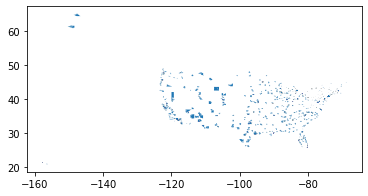

In [23]:
s = time.time()
print('constructing data geodataframe...')
msa_central_city_tracts_gdf = geopandas.GeoDataFrame(tract_data_df.join(tract_shapefiles_gdf, how='left'), crs=tract_shapefiles_gdf.crs, geometry='geometry')
msa_central_city_tracts_gdf.plot()

print('writing out...')
msa_central_city_tracts_gdf.to_file(cities_tracts_dir+'all_cities.shp')
e = time.time()
g = g + (e-s)
print('Wrote data for {0:,.0f} tracts in {1:,.0f} seconds!'.format(len(msa_central_city_tracts_gdf), e-s))


# Get only the columns we need, in the right order

In [ ]:


# new_columns += data_gdf.columns.tolist()[0:9]   # geographic information about the census tract
# new_columns += data_gdf.columns.tolist()[18:20]  # split county indicator and population classification from CRA data, probably not useful
# new_columns += data_gdf.columns.tolist()[115:118] # geodata from ACS5
# new_columns += data_gdf.columns.tolist()[124:125]  # owner-occupied housing units (we don't use this yet)
# new_columns += data_gdf.columns.tolist()[194:195]  # community statistical area (useful only for Baltimore)
# #
# new_columns += data_gdf.columns.tolist()[10:11]   # as is traditional, geometry goes last


data_gdf = geopandas.GeoDataFrame(data_gdf, crs=state_tracts_gdf.crs)

output_gdf = data_gdf[new_columns]
#data_gdf[new_columns].crs

e = time.time()
g = g + (e-s)

#output_gdf[output_gdf.columns.tolist()[:-1]].columns.tolist()
print('Done in {0:,.1f} seconds!'.format(e-s))
## #

In [ ]:
s = time.time()
print('writing output data...')
# output_gdf.reset_index().shape  # (398,197)
# output_gdf[output_gdf.columns.tolist()[:-1]].reset_index().shape  # (398, 196)

output_gdf.reset_index().to_file(output_data_dir+'{0}.shp'.format(city.replace(".","").replace(" ","_").lower()))
output_gdf[output_gdf.columns.tolist()[:-1]].reset_index().to_csv(output_data_dir+'{0}_no_geo.csv'.format(city.replace(".","").replace(" ","_").lower()))

e = time.time()

print('Output file written in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


In [ ]:
# ggdf = geopandas.read_file(output_data_dir+'{0:}.shp'.format(city.replace(" ","_").lower()))
# ggdf.plot(column='pct_black')#edgecolor='white')
# plt.show()
# #ggdf.head(1).T

In [ ]:
# output_gdf.columns.tolist()